In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from typing import Any, Dict, Optional, Tuple
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter


import numpy as np
import pandas as pd

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [ ]:
pd.options.display.width = 1200
matplotlib.rc('figure', figsize=(10,3), dpi=200)

In [ ]:
datafolder = "/content/drive/MyDrive/Colab Notebooks/AI4T/CNN Trading Agent/Data/"

In [ ]:
AMZN = pd.read_csv(datafolder+"AMZN.csv", parse_dates=True, index_col="Date")
AMZN

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-09-03,1770.000000,1800.800049,1768.000000,1789.839966,1789.839966,3543000
2019-09-04,1805.000000,1807.630005,1796.229980,1800.619995,1800.619995,2324100
2019-09-05,1821.949951,1842.000000,1815.579956,1840.719971,1840.719971,3310800
2019-09-06,1838.219971,1840.650024,1826.400024,1833.510010,1833.510010,2496900
2019-09-09,1841.000000,1850.000000,1824.609985,1831.349976,1831.349976,2999500
...,...,...,...,...,...,...
2021-08-25,3309.870117,3321.000000,3286.149902,3299.179932,3299.179932,1680300
2021-08-26,3299.000000,3332.000000,3296.000000,3316.000000,3316.000000,2098800
2021-08-27,3333.229980,3352.320068,3313.750000,3349.629883,3349.629883,2391300


plot the adjusted curve for AMZN

In [ ]:
def adjusted_close_symbols(symbols, date_range, periods_=None, freq_="D"):
    """ Joins an empty DataFrame with index, with multiple stocks dataframes. """
    
    try:
      start_, end_ = date_range
    except:
      start_ = date_range
      end_ = None

    # dates is formatted as YYYY-MM-DD
    dates = pd.date_range(start=start_, end=end_, periods=periods_, freq=freq_)

    # An empty dataframe
    df1 = pd.DataFrame(index=dates) # the dataframe only with the index

    for sym in symbols:
        path_to_file = os.path.join(datafolder, "%s.csv" % sym)
        dfSYM = pd.read_csv(path_to_file, index_col="Date", parse_dates=True, usecols=["Date", "Adj Close"]) # na_values=['nan']
        dfSYM = dfSYM.rename(columns= {'Adj Close': sym})
        df1 = df1.join(dfSYM, how="inner")
    return df1

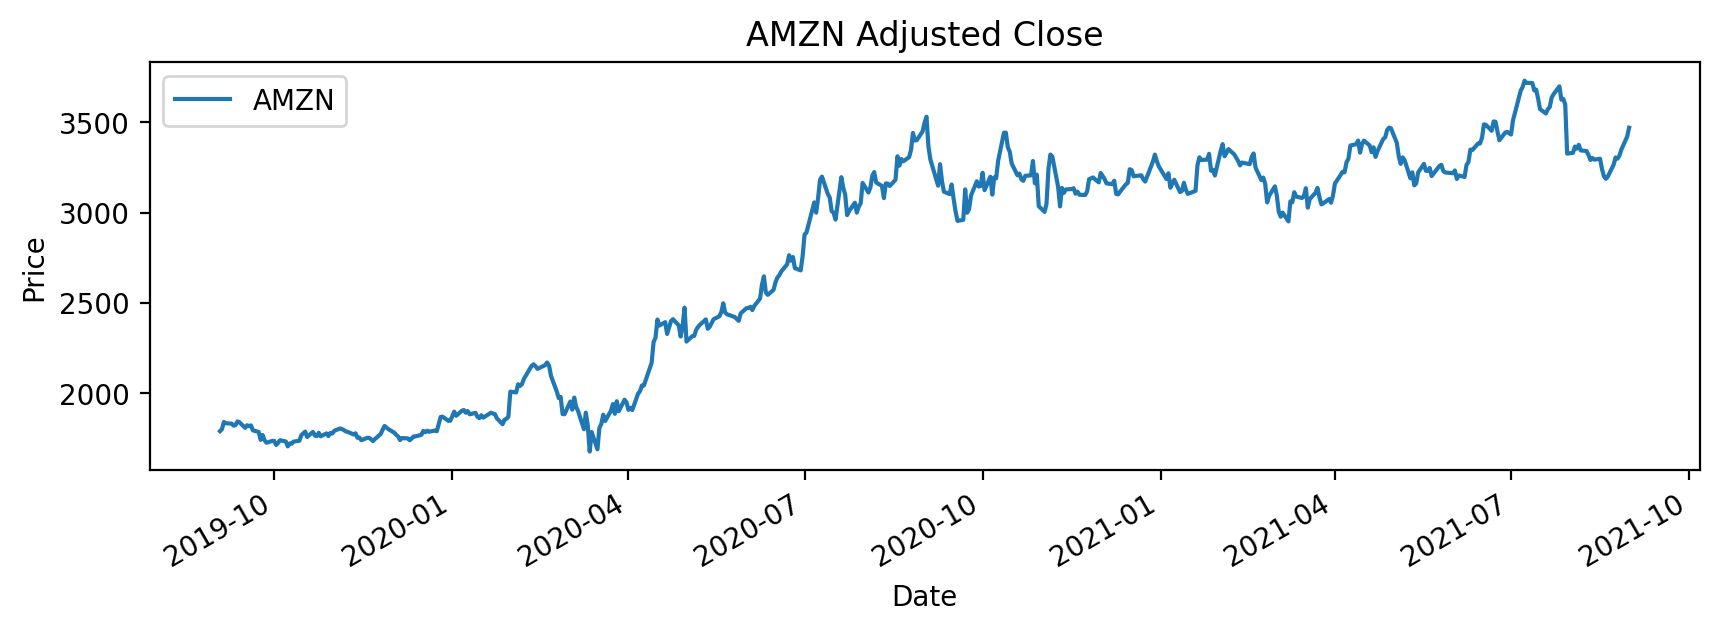

In [ ]:
ALL_SYMBOLS = ["AMZN"]
date_range = ('2019-09-01', '2021-09-01')
periods = None


AMZN = adjusted_close_symbols(ALL_SYMBOLS, date_range, periods_=periods, freq_='B')
# plotting procedure 
ax = AMZN.plot(title="AMZN Adjusted Close")
ax.set_xlabel("Date")
ax.set_ylabel("Price")
plt.legend(loc='upper left', ncol=3) # better visualize the legend
plt.show()

compute and plot the rolling mean

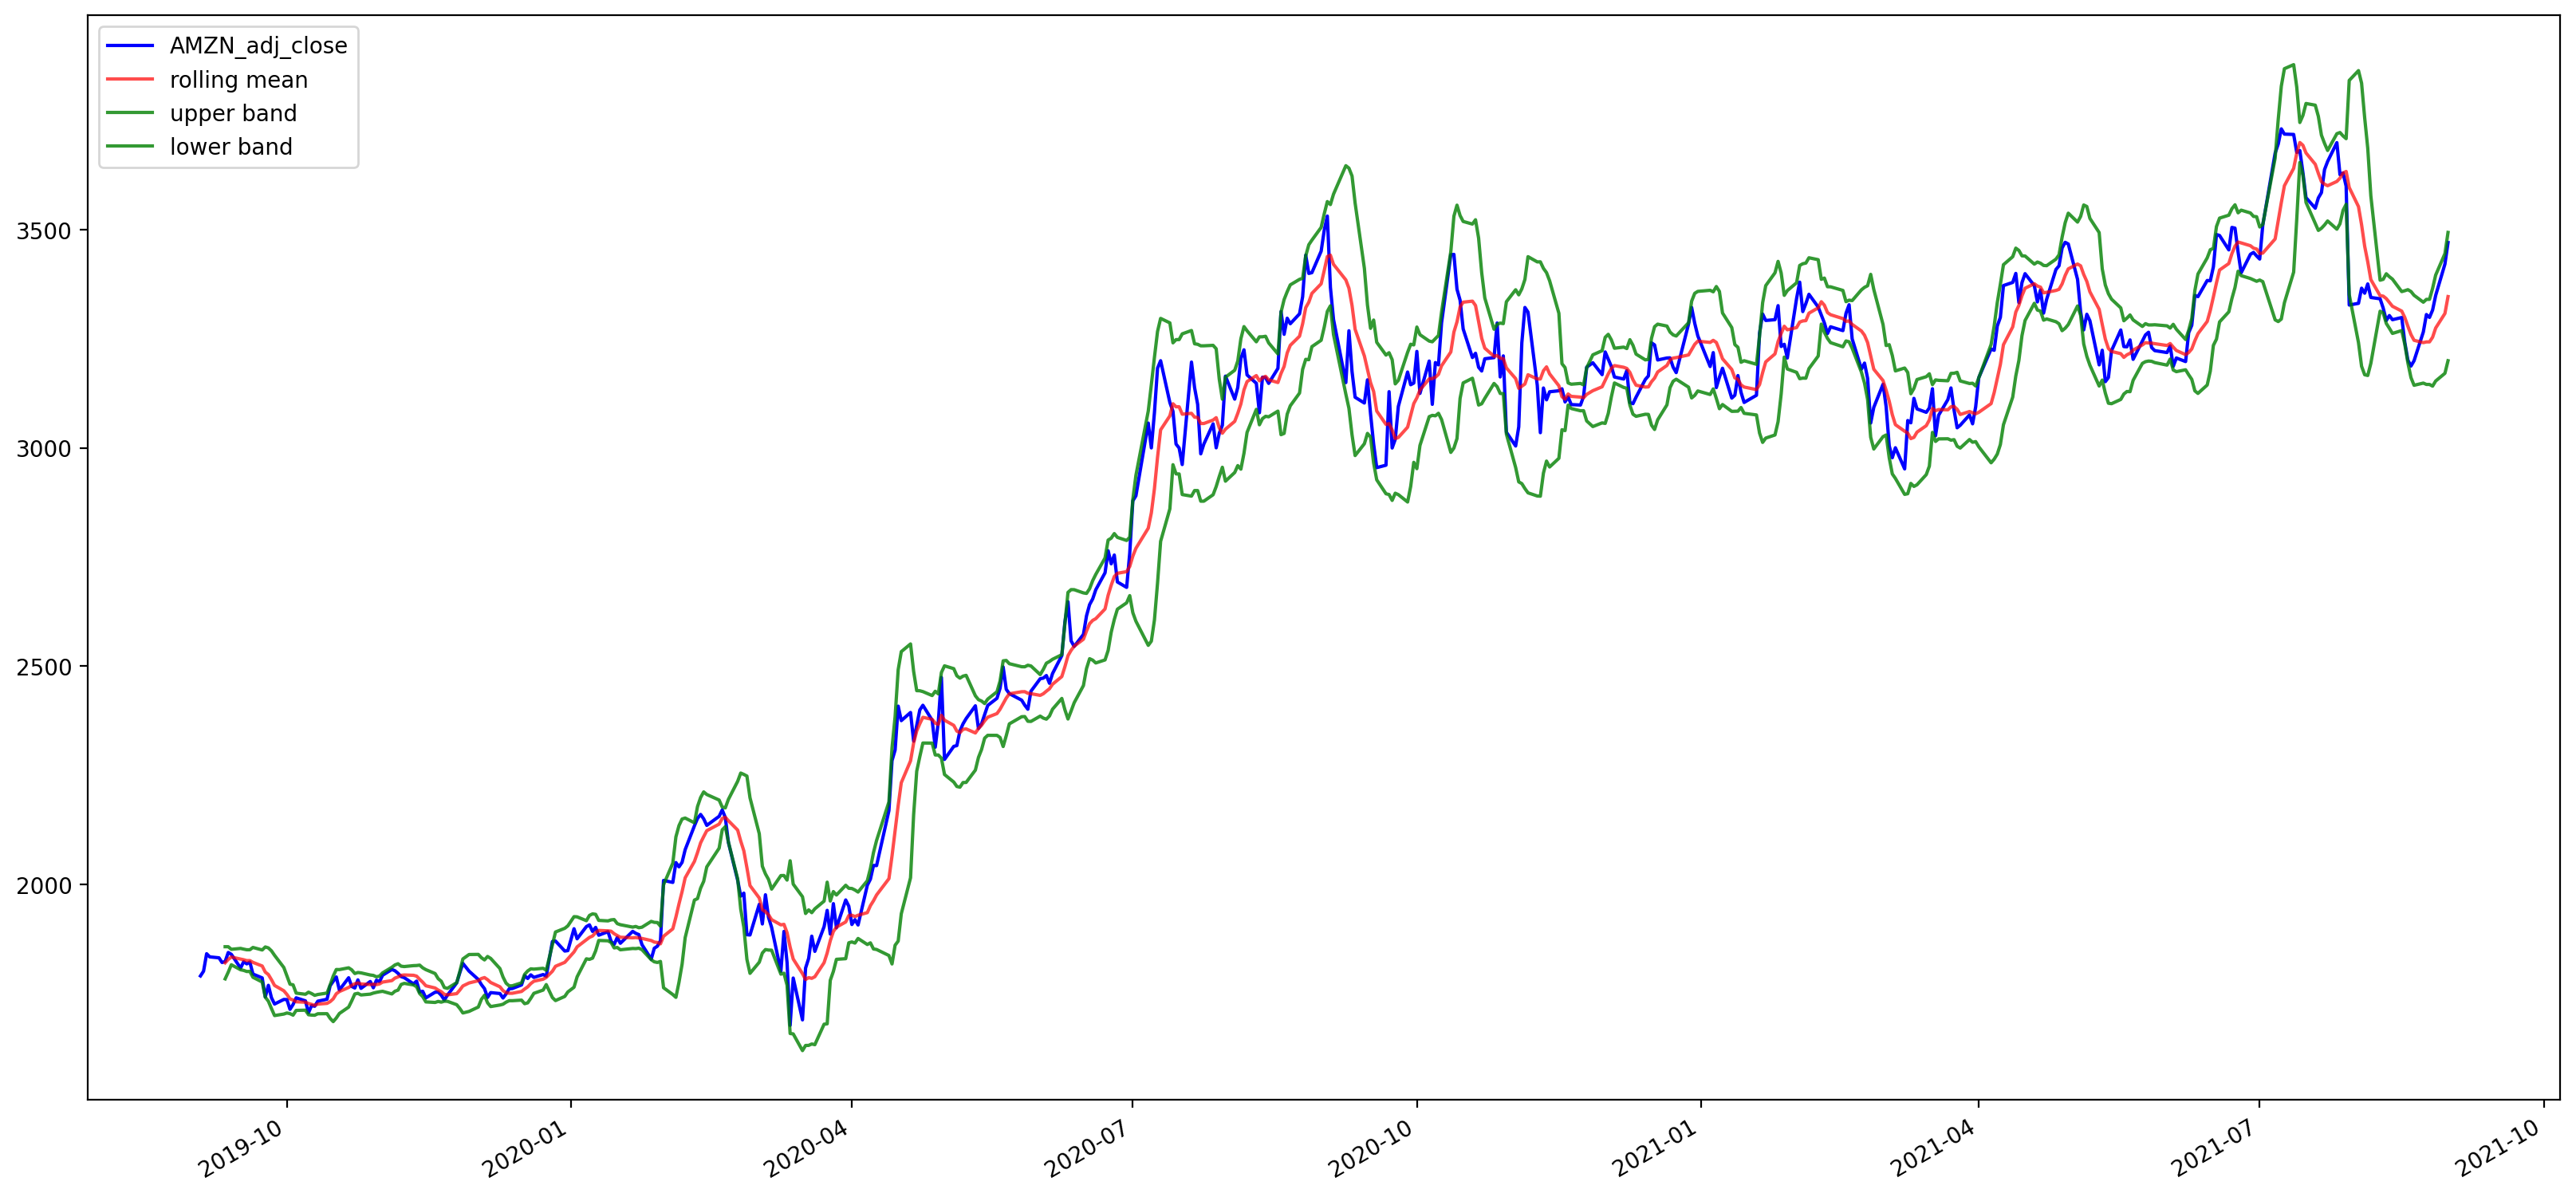

In [ ]:
window_size = 7 # days
F = 2
AMZN["rm"] = AMZN.rolling(window_size).mean()
# upper band
AMZN["ub"] = AMZN.rm + F * AMZN["AMZN"].rolling(window_size).std()
# lower band
AMZN["lb"] = AMZN.rm - F * AMZN["AMZN"].rolling(window_size).std()

dates = AMZN.index.values

fig, ax = plt.subplots(figsize = (20, 10))
ax.plot(dates, AMZN["AMZN"], color = 'b')
ax.plot(dates, AMZN.rm, color = 'r', alpha = 0.7)
ax.plot(dates, AMZN.ub, color = 'g', alpha = 0.8)
ax.plot(dates, AMZN.lb, color = 'g', alpha = 0.8)
ax.legend(("AMZN_adj_close", 'rolling mean', 'upper band', 'lower band'))

plt.gcf().autofmt_xdate()
plt.show()

In [ ]:
# adjusted closing prices
ajp = AMZN["AMZN"].values

In [ ]:
def past_avg_closing_prices(df, sym, window_shape=3):
   """computes the avg closing price of a stock in the past K timeslots wrt d, 'd' included"""

   K = window_shape
   return df.eval(sym).rolling(K, closed="right").mean() # the day d is included

In [ ]:
def future_avg_closing_prices(df, sym, window_shape=3):
  """computes the avg closing price of a stock in the future K timeslots wrt d, 'd' excluded"""

  K = window_shape
  return df.eval(sym).rolling(K, closed="right").mean().shift(-K) # center must be True, the shift is -2 since we are looking at the future, d excluded

In [ ]:
K = window_size
AMZN["B_d"] = past_avg_closing_prices(AMZN,"AMZN", window_shape=K)
AMZN["F_d"] = future_avg_closing_prices(AMZN,"AMZN", window_shape=K)
AMZN["slope_d"] = AMZN.F_d - AMZN.B_d
AMZN["FB_mean"] = (AMZN.F_d + AMZN.B_d)/2


# what "mean" to use? Global mean? Mean defined over the K days before?
AMZN["global_mean"] = AMZN.AMZN.mean()
AMZN["cum_mean"] = AMZN.AMZN.expanding().mean() # WONT BE USED ANYMORE


# how to properly define the std. dev? Over the whole period of 2K days? only the left portion (past K days)?

# ALT. 1: GLOBAL MEAN AND PAST K DAYS
AMZN["std_dev_ALT1"] = np.sqrt(((AMZN.AMZN - AMZN.global_mean)**2).rolling(K).sum()/K)

# ALT. 2: B_d mean AND PAST K DAYS
AMZN["lists_past"] = [i.values for i in list(AMZN.AMZN.rolling(K))]
AMZN["std_dev_ALT2"] = [np.sqrt(i.sum()/K) for i in ((AMZN.lists_past - AMZN.B_d)**2).values]

# ALT. 3: FB mean and PAST/FUTURE K DAYS 
AMZN["lists_future"] = AMZN.lists_past.shift(-K) # it causes problem later -> must remove the rows with nan
AMZN["partial_dev_1"] = [i.sum()/K for i in ((AMZN.lists_past - AMZN.FB_mean)**2).values]

AMZN.dropna(subset=["lists_past","lists_future"], inplace=True)

AMZN["partial_dev_2"] = [i.sum()/(2*K) for i in ((AMZN.lists_future - AMZN.FB_mean)**2).values]
AMZN["std_dev_ALT3"] = np.sqrt( (AMZN.partial_dev_1 + AMZN.partial_dev_2)/2 )

AMZN.drop(columns=["partial_dev_1","partial_dev_2","lists_past","lists_future"], inplace=True)
AMZN.dropna(subset=["std_dev_ALT1","std_dev_ALT2","std_dev_ALT3"], inplace=True)
AMZN

,AMZN,rm,ub,lb,B_d,F_d,slope_d,FB_mean,global_mean,cum_mean,std_dev_ALT1,std_dev_ALT2,std_dev_ALT3
2019-09-11,1822.989990,1819.939994,1856.773757,1783.106231,1819.939994,1820.914289,0.974295,1820.427142,2736.399459,1819.939994,916.618065,17.050719,14.428053
2019-09-12,1843.550049,1827.612863,1856.760782,1798.464944,1827.612863,1812.592861,-15.020002,1820.102862,2736.399459,1822.891251,908.886755,13.492865,14.340305
2019-09-13,1839.339966,1833.144287,1850.829219,1815.459356,1833.144287,1798.631435,-34.512852,1815.887861,2736.399459,1824.718886,903.292269,8.186532,20.852617
2019-09-16,1807.839966,1828.447144,1852.909506,1803.984781,1828.447144,1792.987148,-35.459996,1810.717146,2736.399459,1823.030994,908.022927,11.323874,22.353135
2019-09-17,1822.550049,1826.881435,1851.234310,1802.528560,1826.881435,1781.171422,-45.710013,1804.026428,2736.399459,1822.987272,909.587885,11.273191,26.265041
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-16,3298.989990,3313.722865,3358.399684,3269.046047,3313.722865,3243.101423,-70.621442,3278.412144,2736.399459,2723.905937,577.693720,20.681348,40.727689
2021-08-17,3241.959961,3299.011440,3360.408798,3237.614081,3299.011440,3253.678571,-45.332868,3276.345006,2736.399459,2724.954630,563.329407,28.421454,38.219663
2021-08-18,3201.219971,3278.918562,3362.802181,3195.034943,3278.918562,3274.879987,-4.038574,3276.899275,2736.399459,2725.916782,543.906969,38.830570,39.327398
2021-08-19,3187.750000,3259.928571,3358.579636,3161.277507,3259.928571,3308.282854,48.354283,3284.105713,2736.399459,2726.847897,525.517048,45.666569,49.892178


In [ ]:
AMZN.loc[:,"label_ALT1"] = np.nan
AMZN.loc[:,"label_ALT2"] = np.nan
AMZN.loc[:,"label_ALT3"] = np.nan

Create the labels according to ALT1

In [ ]:
AMZN.loc[[AMZN.slope_d > 0 ][0].values, "label_ALT1"] = 2 # rise
AMZN.loc[[AMZN.slope_d < 0 ][0].values, "label_ALT1"] = 3 # fall
AMZN.loc[[ (AMZN.AMZN > (AMZN.global_mean + AMZN.std_dev_ALT1)) & AMZN.slope_d > 0 ][0].values, "label_ALT1"] = 1 # rise plus
AMZN.loc[[ (AMZN.AMZN < (AMZN.global_mean - AMZN.std_dev_ALT1)) & AMZN.slope_d < 0 ][0].values, "label_ALT1"] = 4 # fall plus

Create the labels according to ALT2

In [ ]:
AMZN.loc[[AMZN.slope_d > 0 ][0].values, "label_ALT2"] = 2 # rise
AMZN.loc[[AMZN.slope_d < 0 ][0].values, "label_ALT2"] = 3 # fall
AMZN.loc[[ (AMZN.AMZN > (AMZN.B_d + AMZN.std_dev_ALT2)) & AMZN.slope_d > 0 ][0].values, "label_ALT2"] = 1 # rise plus
AMZN.loc[[ (AMZN.AMZN < (AMZN.B_d - AMZN.std_dev_ALT2)) & AMZN.slope_d < 0 ][0].values, "label_ALT2"] = 4 # fall plus

Create the labels according to ALT3

In [ ]:
AMZN.loc[[AMZN.slope_d > 0 ][0].values, "label_ALT3"] = 2 # rise
AMZN.loc[[AMZN.slope_d < 0 ][0].values, "label_ALT3"] = 3 # fall
AMZN.loc[[ (AMZN.AMZN > (AMZN.FB_mean + AMZN.std_dev_ALT3)) & AMZN.slope_d > 0 ][0].values, "label_ALT3"] = 1 # rise plus
AMZN.loc[[ (AMZN.AMZN < (AMZN.FB_mean - AMZN.std_dev_ALT3)) & AMZN.slope_d < 0 ][0].values, "label_ALT3"] = 4 # fall plus

Check the labels

In [ ]:
AMZN

,AMZN,rm,ub,lb,B_d,F_d,slope_d,FB_mean,global_mean,cum_mean,std_dev_ALT1,std_dev_ALT2,std_dev_ALT3,label_ALT1,label_ALT2,label_ALT3
2019-09-11,1822.989990,1819.939994,1856.773757,1783.106231,1819.939994,1820.914289,0.974295,1820.427142,2736.399459,1819.939994,916.618065,17.050719,14.428053,2.0,2.0,2.0
2019-09-12,1843.550049,1827.612863,1856.760782,1798.464944,1827.612863,1812.592861,-15.020002,1820.102862,2736.399459,1822.891251,908.886755,13.492865,14.340305,3.0,1.0,1.0
2019-09-13,1839.339966,1833.144287,1850.829219,1815.459356,1833.144287,1798.631435,-34.512852,1815.887861,2736.399459,1824.718886,903.292269,8.186532,20.852617,3.0,3.0,1.0
2019-09-16,1807.839966,1828.447144,1852.909506,1803.984781,1828.447144,1792.987148,-35.459996,1810.717146,2736.399459,1823.030994,908.022927,11.323874,22.353135,3.0,3.0,3.0
2019-09-17,1822.550049,1826.881435,1851.234310,1802.528560,1826.881435,1781.171422,-45.710013,1804.026428,2736.399459,1822.987272,909.587885,11.273191,26.265041,3.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-16,3298.989990,3313.722865,3358.399684,3269.046047,3313.722865,3243.101423,-70.621442,3278.412144,2736.399459,2723.905937,577.693720,20.681348,40.727689,3.0,3.0,3.0
2021-08-17,3241.959961,3299.011440,3360.408798,3237.614081,3299.011440,3253.678571,-45.332868,3276.345006,2736.399459,2724.954630,563.329407,28.421454,38.219663,3.0,3.0,3.0
2021-08-18,3201.219971,3278.918562,3362.802181,3195.034943,3278.918562,3274.879987,-4.038574,3276.899275,2736.399459,2725.916782,543.906969,38.830570,39.327398,3.0,3.0,3.0
2021-08-19,3187.750000,3259.928571,3358.579636,3161.277507,3259.928571,3308.282854,48.354283,3284.105713,2736.399459,2726.847897,525.517048,45.666569,49.892178,2.0,2.0,2.0


PLOT ALT1

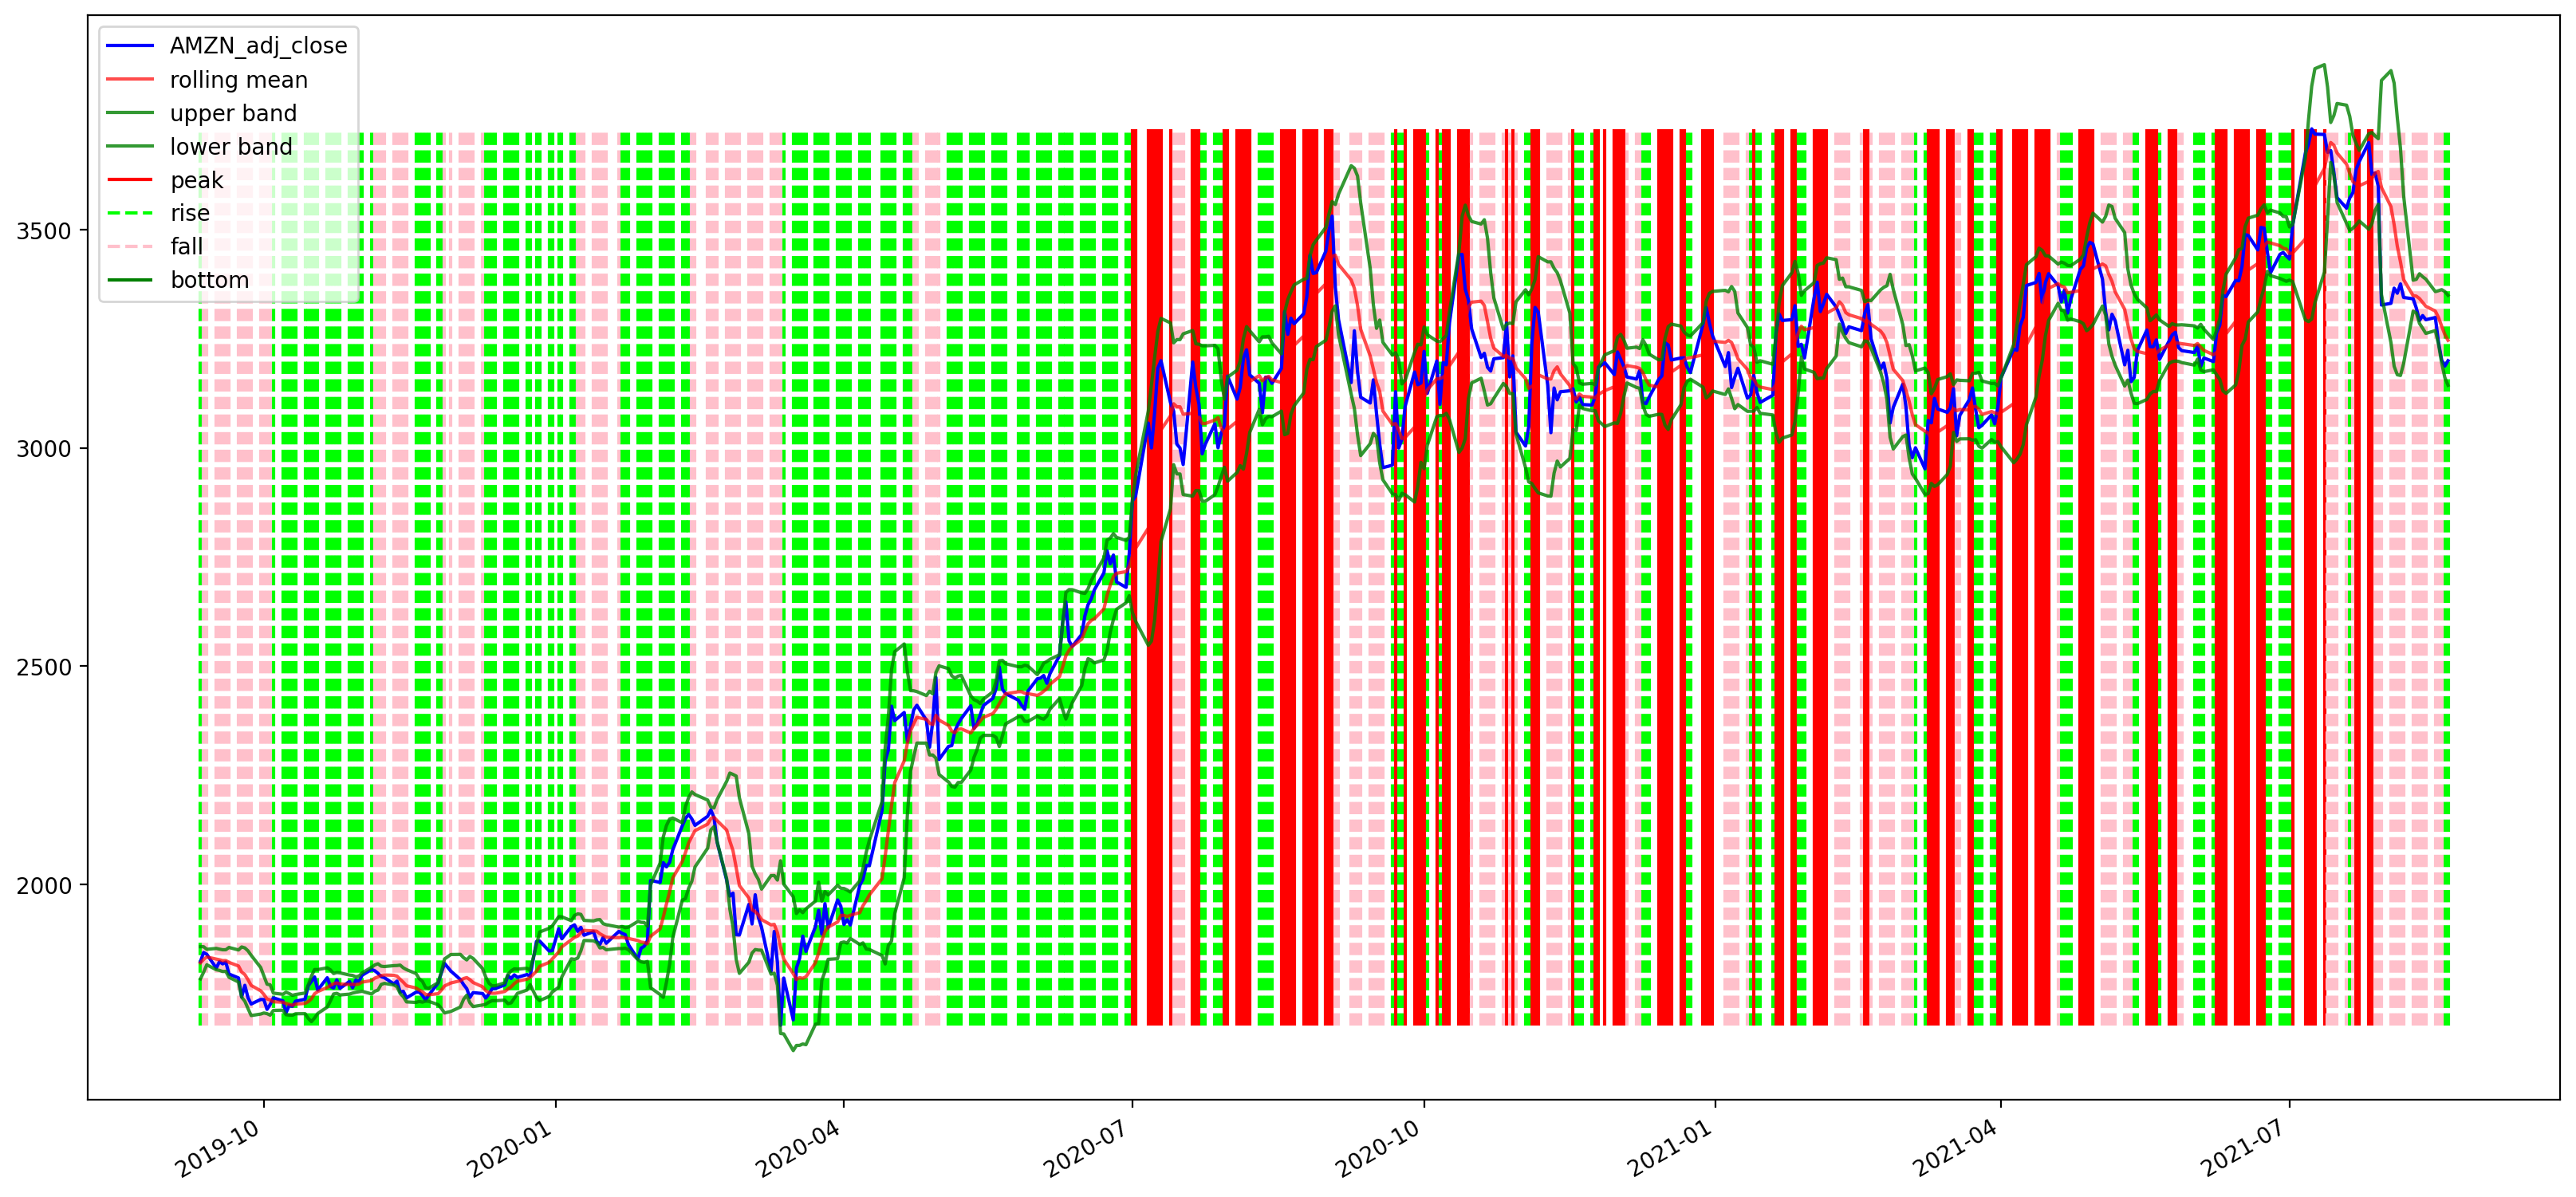

In [ ]:
new_dates = AMZN.index.values

fig, ax = plt.subplots(figsize = (20, 10))
ax.plot(new_dates, AMZN["AMZN"], color = 'b')
ax.vlines(AMZN[AMZN.label_ALT1==1].index.values, ymin=AMZN.AMZN.min(), ymax=AMZN.AMZN.max(), label="peak", color="red", linestyle="solid")   # peak
ax.vlines(AMZN[AMZN.label_ALT1==2].index.values, ymin=AMZN.AMZN.min(), ymax=AMZN.AMZN.max(), label="rise", color="lime", linestyle="dashed")  # rise
ax.vlines(AMZN[AMZN.label_ALT1==3].index.values, ymin=AMZN.AMZN.min(), ymax=AMZN.AMZN.max(), label="fall", color="pink", linestyle="dashed")  # fall
ax.vlines(AMZN[AMZN.label_ALT1==4].index.values, ymin=AMZN.AMZN.min(), ymax=AMZN.AMZN.max(), label="bottom", color="green", linestyle="solid") # bottom

ax.plot(new_dates, AMZN.rm, color = 'r', alpha = 0.7)
ax.plot(new_dates, AMZN.ub, color = 'g', alpha = 0.8)
ax.plot(new_dates, AMZN.lb, color = 'g', alpha = 0.8)
ax.legend(("AMZN_adj_close", 'rolling mean', 'upper band', 'lower band','peak', 'rise', 'fall', 'bottom'))

plt.gcf().autofmt_xdate()
plt.show()

PLOT ALT2

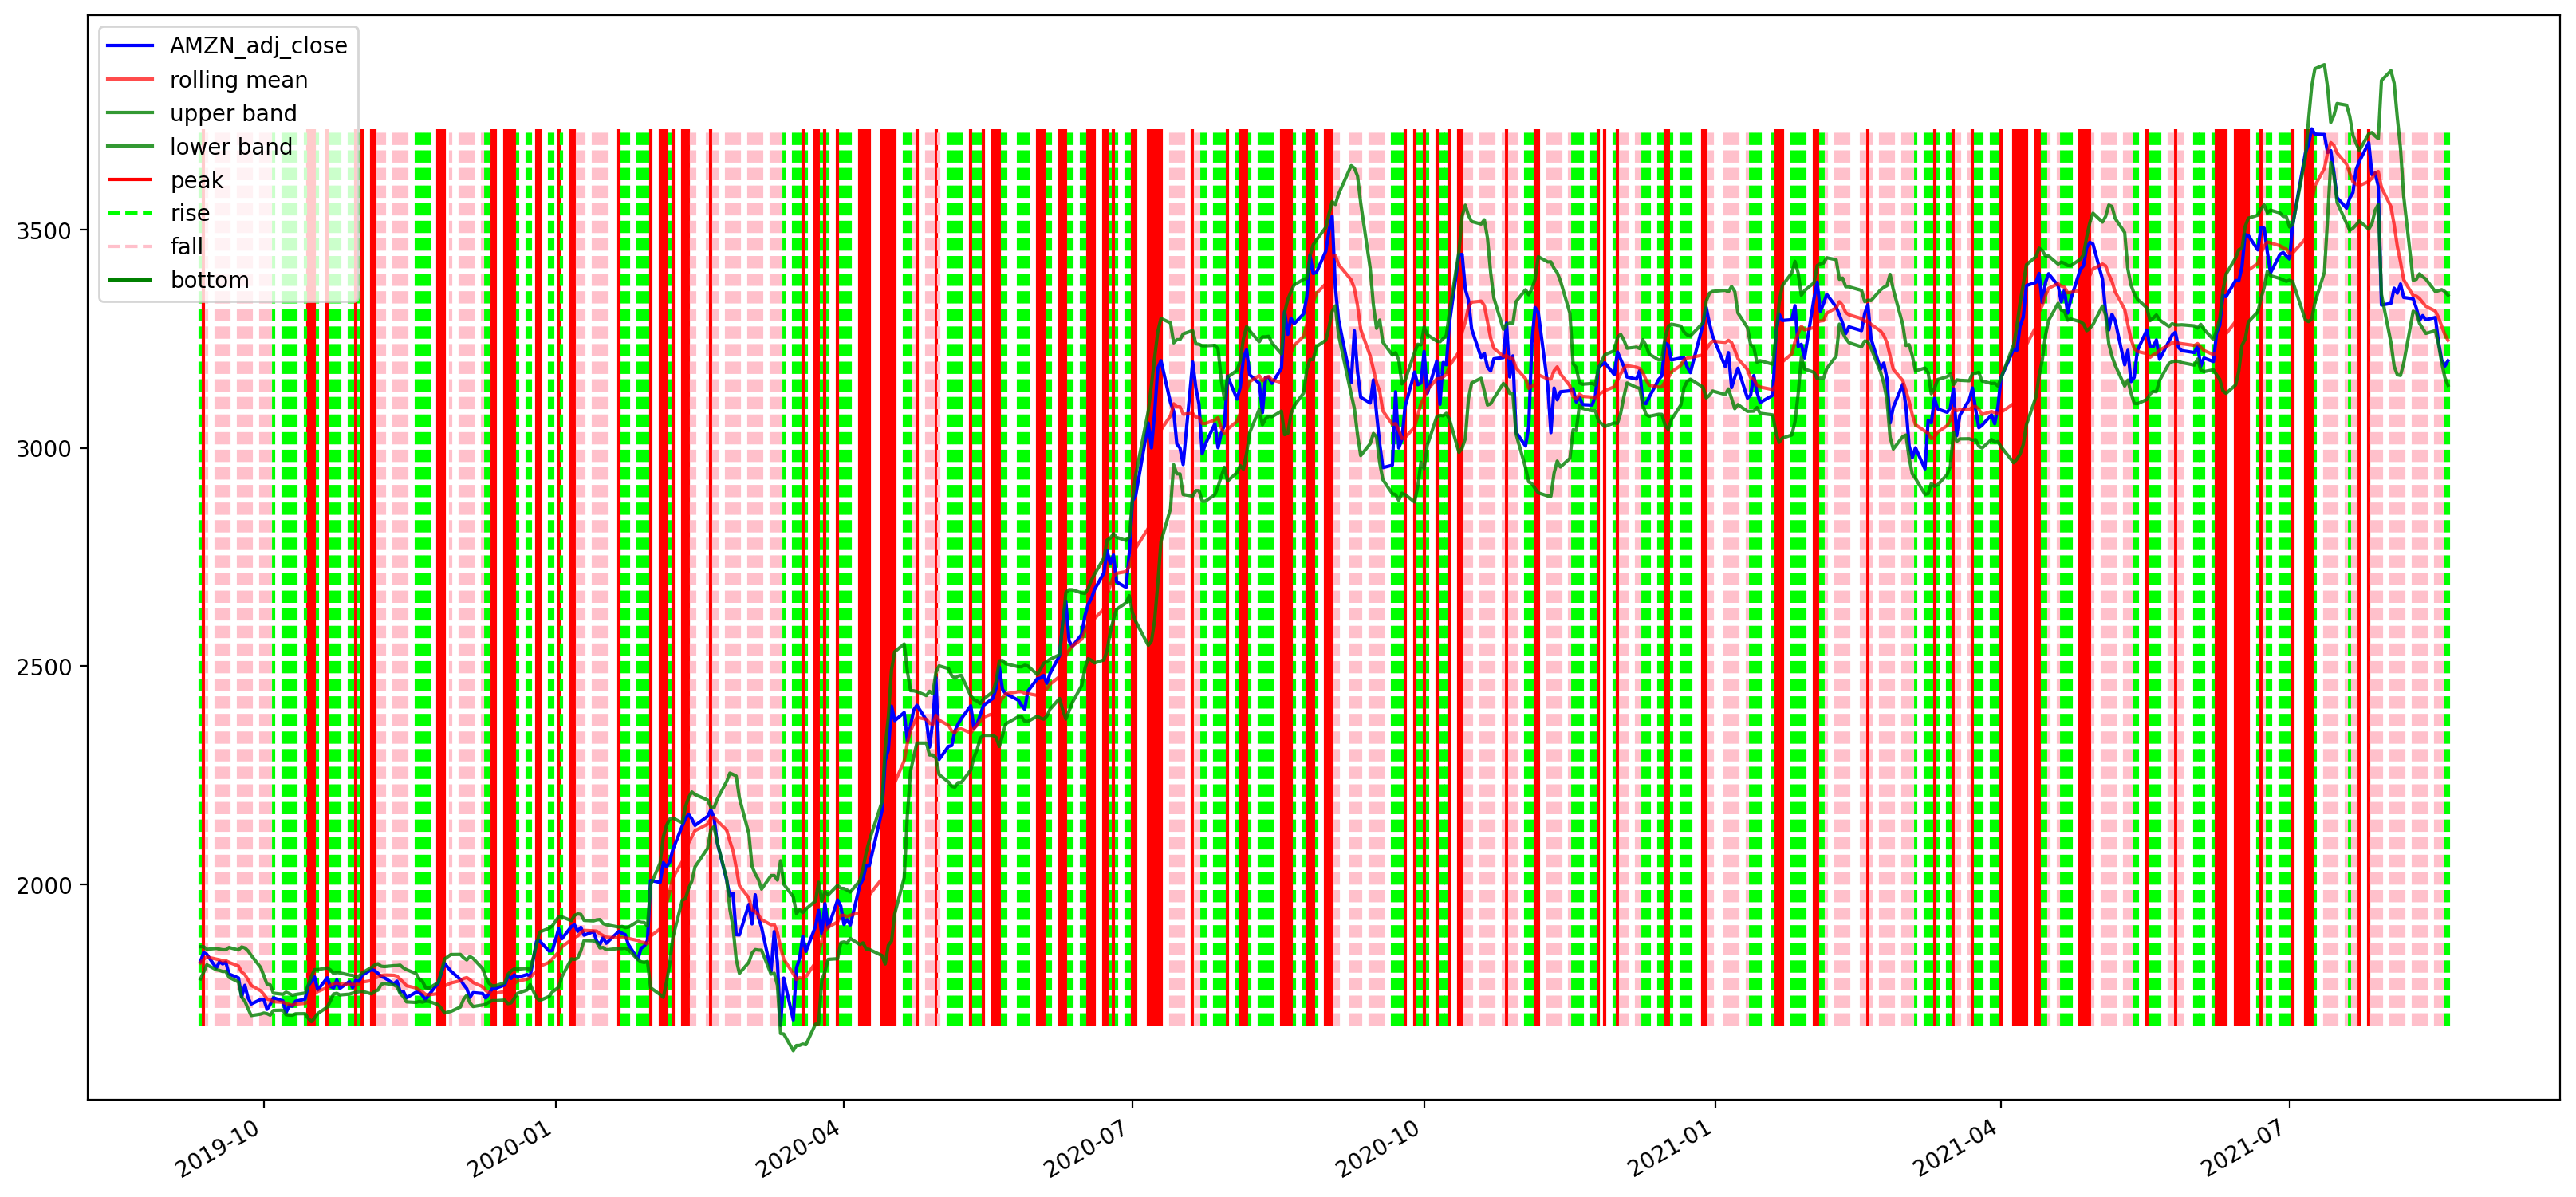

In [ ]:
new_dates = AMZN.index.values

fig, ax = plt.subplots(figsize = (20, 10))
ax.plot(new_dates, AMZN["AMZN"], color = 'b')
ax.vlines(AMZN[AMZN.label_ALT2==1].index.values, ymin=AMZN.AMZN.min(), ymax=AMZN.AMZN.max(), color="red", linestyle="solid")   # peak
ax.vlines(AMZN[AMZN.label_ALT2==2].index.values, ymin=AMZN.AMZN.min(), ymax=AMZN.AMZN.max(), color="lime", linestyle="dashed")  # rise
ax.vlines(AMZN[AMZN.label_ALT2==3].index.values, ymin=AMZN.AMZN.min(), ymax=AMZN.AMZN.max(), color="pink", linestyle="dashed")  # fall
ax.vlines(AMZN[AMZN.label_ALT2==4].index.values, ymin=AMZN.AMZN.min(), ymax=AMZN.AMZN.max(), color="green", linestyle="solid") # bottom

ax.plot(new_dates, AMZN.rm, color = 'r', alpha = 0.7)
ax.plot(new_dates, AMZN.ub, color = 'g', alpha = 0.8)
ax.plot(new_dates, AMZN.lb, color = 'g', alpha = 0.8)
ax.legend(("AMZN_adj_close", 'rolling mean', 'upper band', 'lower band','peak', 'rise', 'fall', 'bottom'))

plt.gcf().autofmt_xdate()
plt.show()

PLOT ALT3

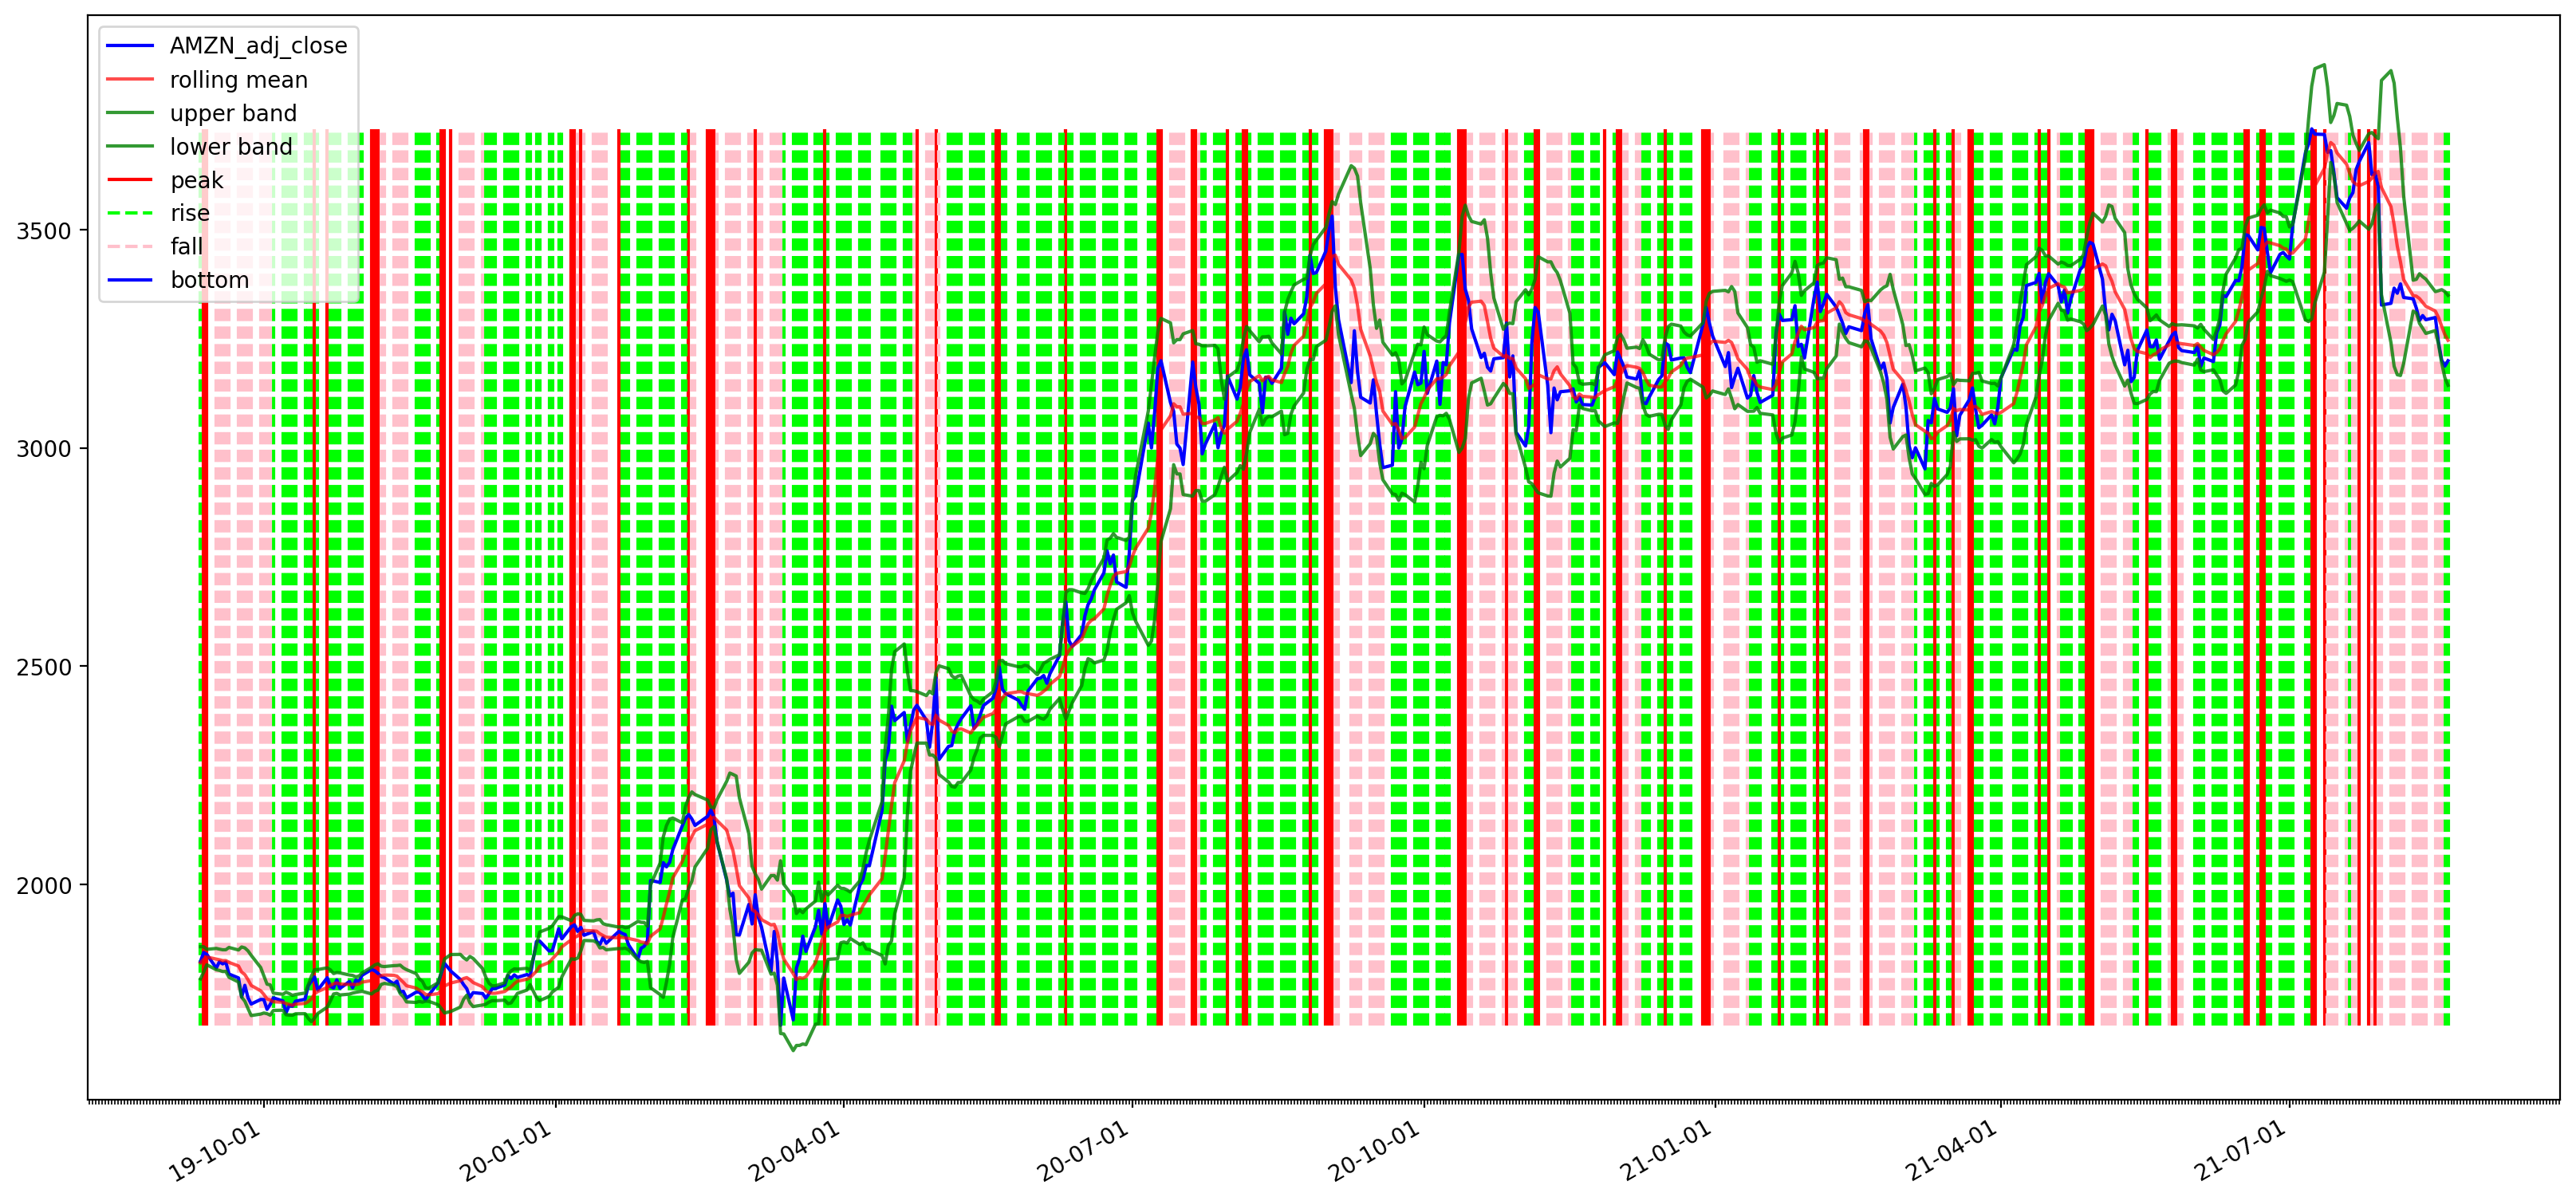

In [ ]:
new_dates = AMZN.index.values

fig, ax = plt.subplots(figsize = (20, 10))
ax.plot(new_dates, AMZN["AMZN"], color = 'b')
ax.vlines(AMZN[AMZN.label_ALT3==1].index.values, ymin=AMZN.AMZN.min(), ymax=AMZN.AMZN.max(), color="red", linestyle="solid")   # peak
ax.vlines(AMZN[AMZN.label_ALT3==2].index.values, ymin=AMZN.AMZN.min(), ymax=AMZN.AMZN.max(), color="lime", linestyle="dashed")  # rise
ax.vlines(AMZN[AMZN.label_ALT3==3].index.values, ymin=AMZN.AMZN.min(), ymax=AMZN.AMZN.max(), color="pink", linestyle="dashed")  # fall
ax.vlines(AMZN[AMZN.label_ALT3==4].index.values, ymin=AMZN.AMZN.min(), ymax=AMZN.AMZN.max(), color="blue", linestyle="solid") # bottom

ax.plot(new_dates, AMZN.rm, color = 'r', alpha = 0.7)
ax.plot(new_dates, AMZN.ub, color = 'g', alpha = 0.8)
ax.plot(new_dates, AMZN.lb, color = 'g', alpha = 0.8)
ax.legend(("AMZN_adj_close", 'rolling mean', 'upper band', 'lower band','peak', 'rise', 'fall', 'bottom'))

date_form = DateFormatter("%y-%m-%d")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_minor_locator(mdates.DayLocator()) # set a simple tick each day
plt.gcf().autofmt_xdate()
plt.show()